In [1]:
import jax.numpy as jnp
import pymdp.jax
from fast_structure_learning import *

In [2]:
path_to_file = "dove.mp4"

frames = read_frames_from_mp4(path_to_file)
(observations, locations_matrix, group_indices, sv_discrete_axis, V_per_patch), patch_indices = map_rbg_2_discrete(frames, tile_diameter=32, n_bins=16)
observations = jnp.asarray(observations)
agents, RG, LB = spm_mb_structure_learning(observations, locations_matrix, max_levels=8)

/home/tverbele/Code/python/hackaton/.venv/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3042: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/home/tverbele/Code/python/hackaton/.venv/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3043: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
/home/tverbele/Code/python/hackaton/.venv/lib/python3.11/site-packages/jax/_src/nump

Maximum probability state about factor 0 at time 0: 10
Maximum probability state about factor 0 at time 1: 8
Maximum probability state about factor 0 at time 2: 14
Maximum probability state about factor 0 at time 3: 12
Maximum probability state about factor 0 at time 4: 11
Maximum probability state about factor 0 at time 5: 5
Maximum probability state about factor 0 at time 6: 0
Maximum probability state about factor 0 at time 7: 1
Maximum probability state about factor 0 at time 8: 2
Maximum probability state about factor 0 at time 9: 6
Maximum probability state about factor 0 at time 10: 13
Maximum probability state about factor 0 at time 11: 15
Maximum probability state about factor 0 at time 12: 9
Maximum probability state about factor 0 at time 13: 3
Maximum probability state about factor 0 at time 14: 4
Maximum probability state about factor 0 at time 15: 7
Maximum probability state about factor 0 at time 16: 10
Maximum probability state about factor 0 at time 17: 8
Maximum proba

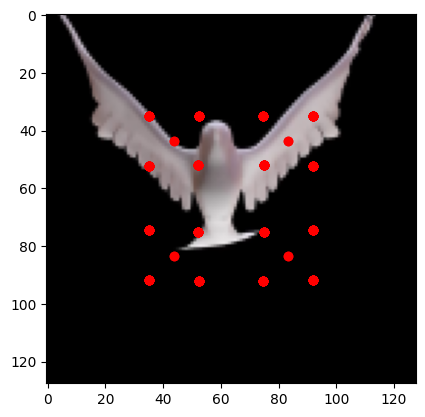

In [11]:
import matplotlib.pyplot as plt

plt.imshow(frames[0])
for locations_matrix in LB:
    plt.scatter(locations_matrix[:,0], locations_matrix[:,1], c='r')
plt.show()

In [12]:
one_hot = jnp.zeros([1, 8])
one_hot = one_hot.at[0, 5].set(1.0)
D = one_hot

In [13]:
from pymdp.jax.control import compute_expected_obs
from jax import vmap
from functools import partial

expected_obs = partial(compute_expected_obs, A_dependencies=agents[-1].A_dependencies)

qo = vmap(expected_obs)([D,], agents[-1].A)

In [14]:
qo

[Array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32),
 Array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32),
 Array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32),
 Array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32),
 Array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32),
 Array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32),
 Array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32),
 Array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32)]

In [15]:
import jax.tree_util as jtu

expected_obs2 = partial(compute_expected_obs, A_dependencies=agents[-2].A_dependencies)

# split this in initial state "D" and path "E"
D2 = qo[::2]
# TODO also transition using this policy matrix?
E2 = jtu.tree_map(lambda x: jnp.expand_dims(jnp.argmax(x), [0]), qo[1::2])
print(E2)

qs_next, _ = agents[-2].infer_empirical_prior(E2, jtu.tree_map(lambda x : jnp.expand_dims(x, 0), D2))

qo2 = vmap(expected_obs2)(D2, agents[-2].A)
qo2_nxt = vmap(expected_obs2)(qs_next, agents[-2].A)

[Array([0], dtype=int32), Array([0], dtype=int32), Array([0], dtype=int32), Array([0], dtype=int32)]


In [17]:
obs1 = jnp.array(qo2)
obs2 = jnp.array(qo2_nxt)
img = map_discrete_2_rgb(obs1[:, 0, :], locations_matrix, group_indices, sv_discrete_axis, V_per_patch, patch_indices, frames.shape[-3:])
img2 = map_discrete_2_rgb(obs2[:, 0, :], locations_matrix, group_indices, sv_discrete_axis, V_per_patch, patch_indices, frames.shape[-3:])
#img = map_discrete_2_rgb(observations[:, 0, :], locations_matrix, group_indices, sv_discrete_axis, V_per_patch, patch_indices, frames.shape[-3:])

In [18]:
print(img.shape, img2.shape)

(2, 3, 128, 128) (2, 3, 128, 128)


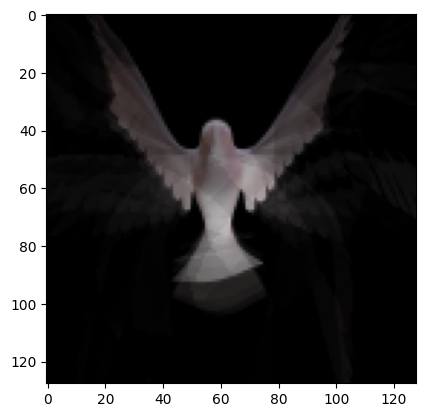

In [19]:
import numpy as onp

def to_img(img):
    im = jnp.transpose(img, (1, 2, 0))
    im /= 255
    im = jnp.clip(im, 0, 1)
    im = (255*im).astype(onp.uint8)
    return im

plt.imshow(to_img(img[0]))


In [20]:
!pip install -q mediapy

/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: pip install --upgrade pip


predictions

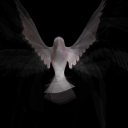

In [22]:
import mediapy

imgs = [to_img(img[0]), to_img(img[1]), to_img(img2[0]), to_img(img2[1])]

with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"predictions": imgs}, fps=1, codec='gif')
